In [1]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

# ATMO 5331 - Homework 4 - Fall 2023
## Due 11:59 PM, Sun 12 Nov, 2023

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import warnings

warnings.filterwarnings('ignore', 'divide by zero')



**1.** Let's compare our dimensionalized, Barnes-style weight function to Gaussian function in `scipy.signal.windows.gaussian`. We understand its nondimensional frequency response quite well using theory from Koch, Trapp and Doswell, etc. However, the functions in `scipy.signal.windows.gaussian` control the cutoff in terms of the standard deviation. Since the functions are mathmatically equivalent, we should be able to reconcile them.

**a.** Using a data spacing of $\Delta=10$ m, what is the nyquist length scale $L_n$, and the spatial sampling frequency $f_s$ and nyquist $f_n$? Calculate these quantities in code from what is given, don't just fill in the values.


In [3]:
delta = 10              # data spacing
Ln = 2 * delta          # Nyquist length scale
fs = 1.0 / delta        # spatial sampling frequency
fn = fs / 2             # Nyquist frequency

#print(Ln, fs, fn, 1.0/Ln)
Ln, fs, fn, 1.0/Ln

(20, 0.1, 0.05, 0.05)

Let's assume we have $N=2048$ samples of data and sample at evenly spaced locations $x$ from $0$ to $(N-1)\Delta$.

To get a feel for what data looks like in the frequncy domain transform, let's look at a step function, a linear ramp, and a sine wave. The function provided below calcualates the Fourier transform and plots its amplitude and phase response. You'll use this plot for the rest of the assignment.

**b.** There is no waviness to the ramp. Why is there amplitude at so many frequencies? 

**c.** When you run the code to show the FFT of the sine wave, why is there amplitude at more than a single frequency?

0.0 20470.0
4.8828125e-05 4.8828125e-05
-0.05 0.049951171875000006 0.05
-20480.0 20480.0


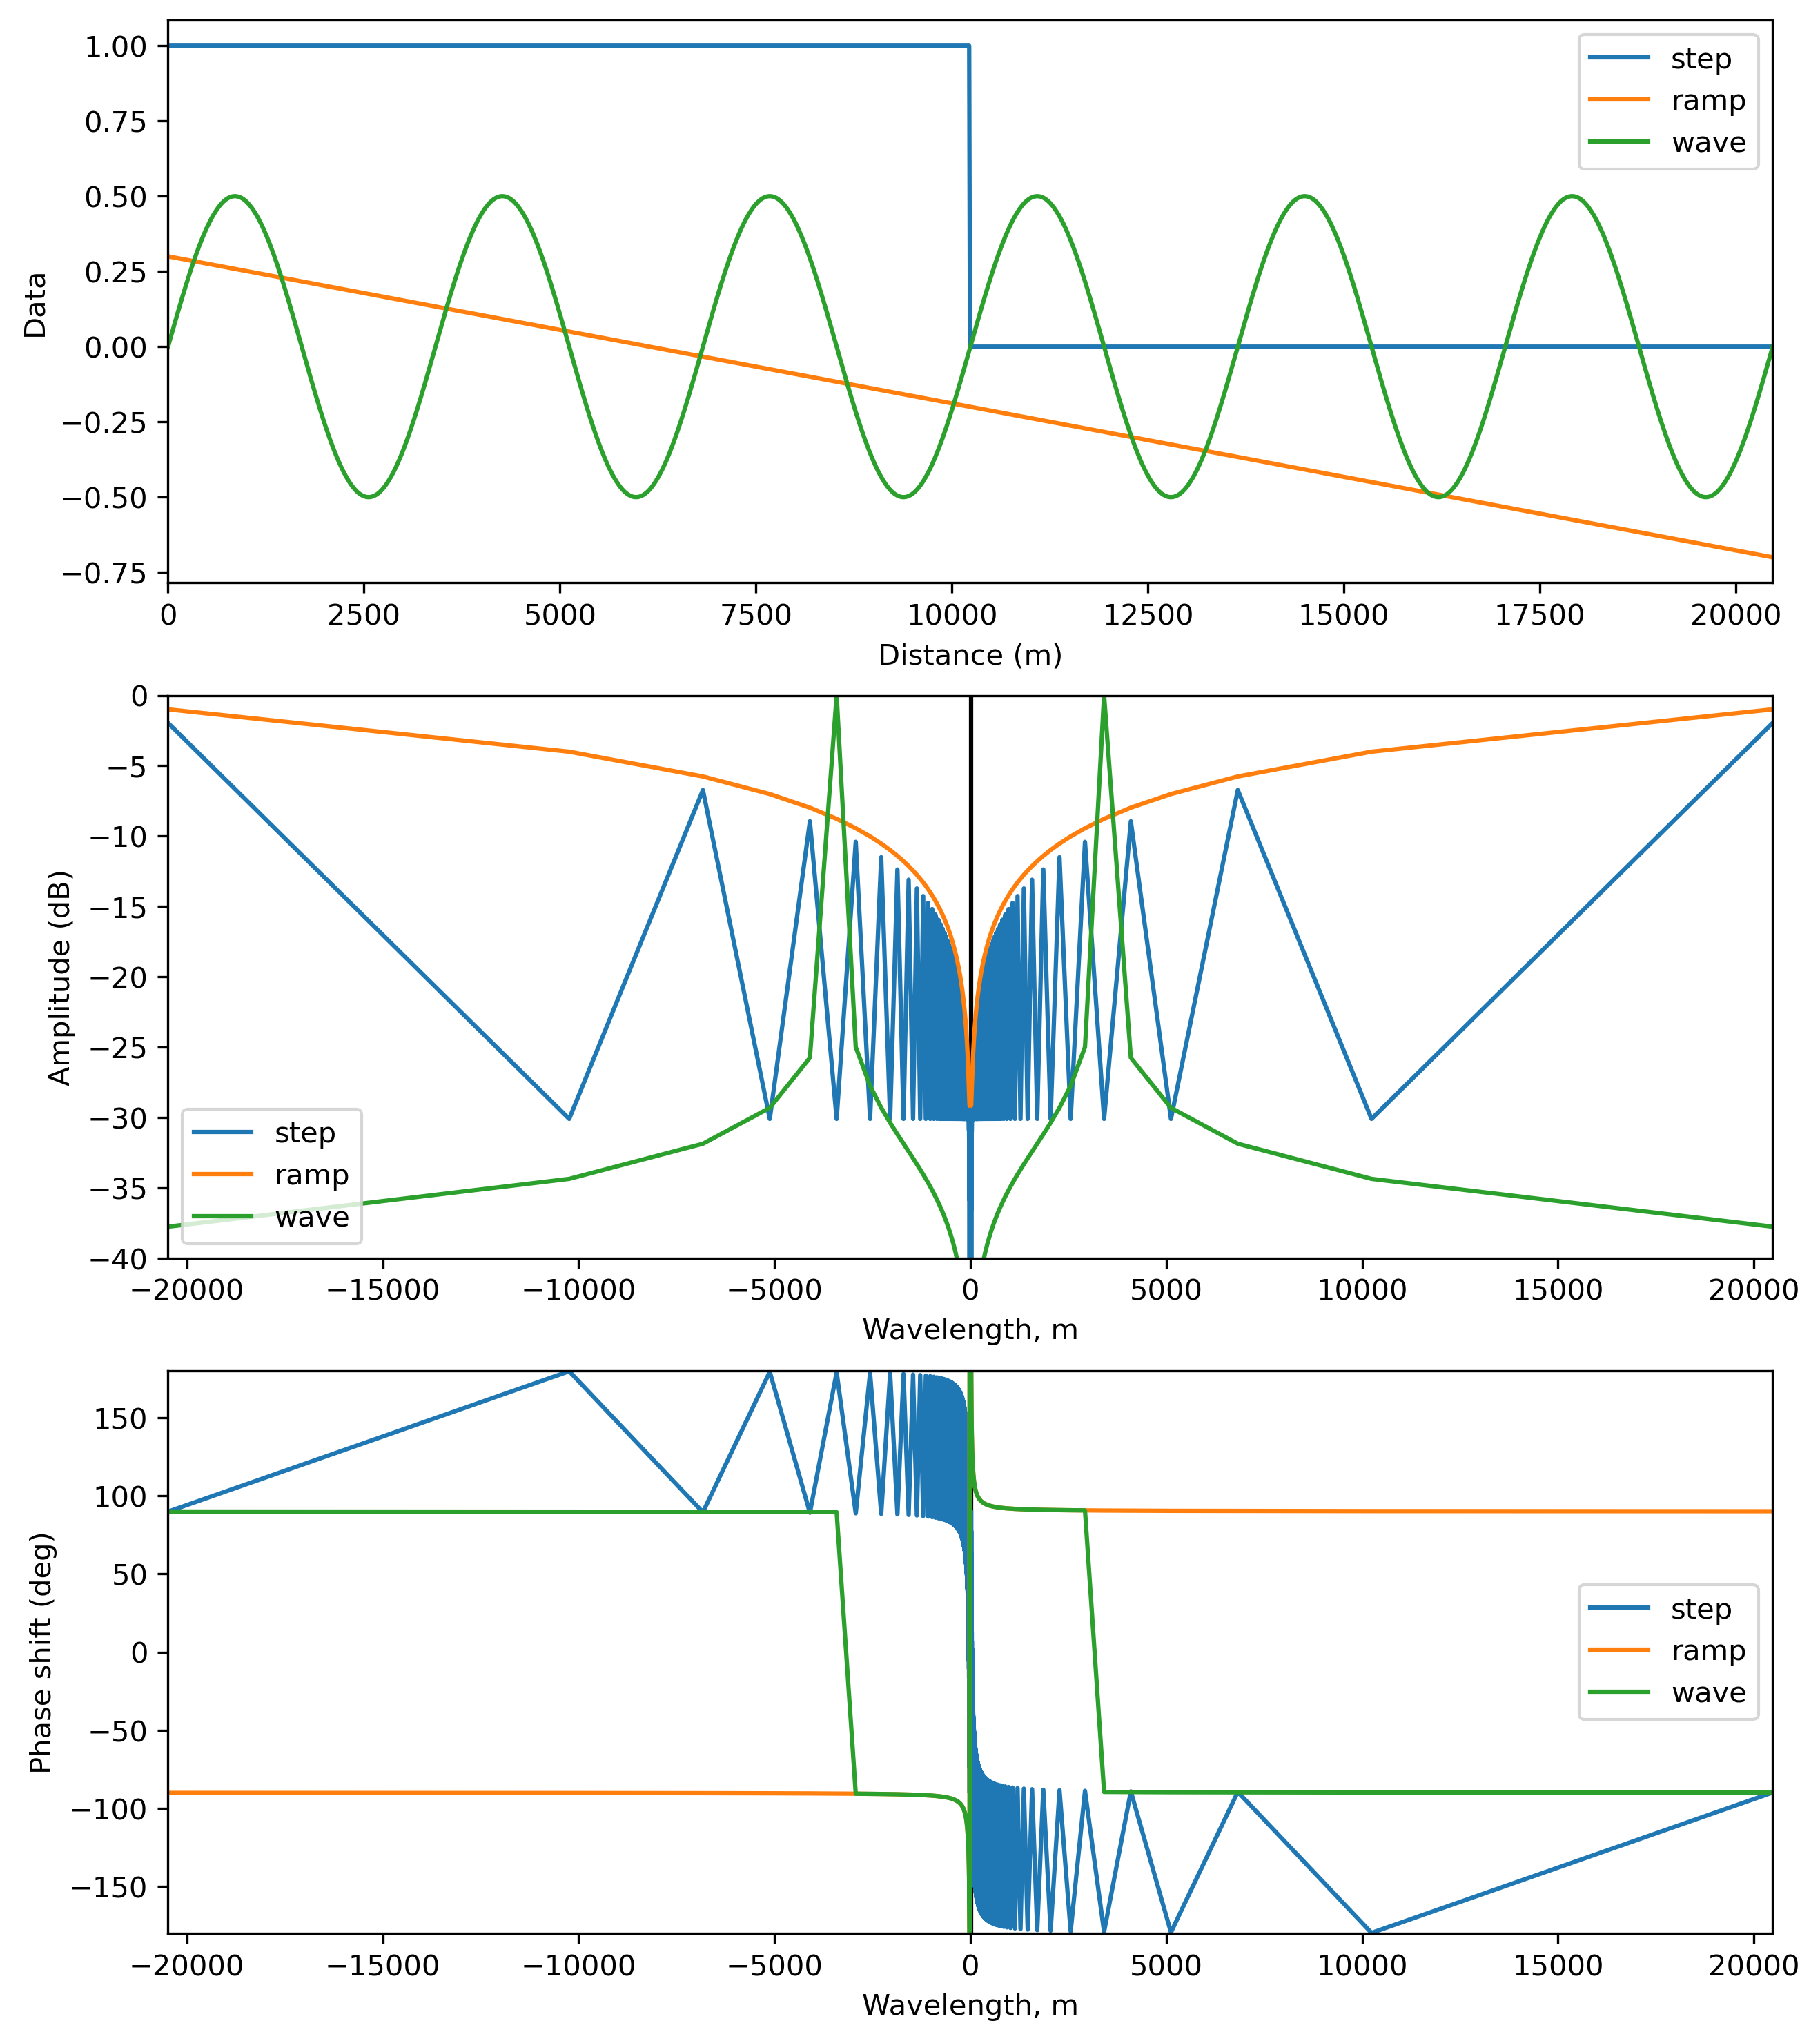

In [4]:
N = 2048

x = np.arange(N, dtype='f8')*delta
print(x.min(), x.max())

freqs = np.fft.fftfreq(N, delta)
df = freqs[1]-freqs[0]
# frequency interval is the same as that calculated theoretically from fs/N
print(df, fs/N)
# and so is the Nyquist
print(freqs.min(), freqs.max(), fn)

fftshift = np.fft.fftshift

def dB(a,base=1.0):
    return 10.0*np.log10(a/base)

def response_plot(signals, x, axs, freq, labels=None, wavelength=False, dB_amp=True):
    """ Signals is a tuple or list (or iterable) of signals.
    """
    if labels is None:
        labels = range(len(signals))
    ax_t, ax_f, ax_p = axs
    
    if wavelength:
        freqs = 1.0/freq
        freq_label = 'Wavelength, m' 
        fmin, fmax = np.nanmin(freqs), -np.nanmin(freqs)
        for ax in [ax_f, ax_p]: ax.axvline(Ln, color='k')
    else:
        freqs = freq
        freq_label = 'Spatial Frequency, m^-1' 
        fmin, fmax = np.nanmin(freqs), np.nanmax(freqs)
    print(fmin, fmax)
    
    for signal, label in zip(signals, labels):
        fft_s = np.fft.fft(signal/signal.sum(), signal.shape[0])
        amplitude = np.abs(fftshift(fft_s))
        amplitude /= amplitude.max()
        phase = np.angle(fftshift(fft_s))
        
#         print(amplitude.max(), amplitude.min(), np.all(~np.isfinite(amplitude)))
#         print(phase.max(), phase.min())

        ax_t.plot(x, signal, label=label)
        ax_t.set_ylabel('Data')
        ax_t.set_xlabel('Distance (m)')
        ax_t.set_xlim(x.min(), x.max())
        john = ax_t.legend()

        if dB_amp:
            ax_f.plot(fftshift(freqs), dB(amplitude), label=label)
            ax_f.set_ylim(-40,0)
            ax_f.set_ylabel('Amplitude (dB)')
        else:
            ax_f.plot(fftshift(freqs), amplitude, label=label)
            ax_f.set_ylim(0,1)
            ax_f.set_ylabel('Amplitude (linear)')
        ax_f.set_xlim(fmin, fmax)
        ax_f.set_xlabel(freq_label)
        john = ax_f.legend()

        ax_p.plot(fftshift(freqs), np.degrees(phase), label=label)
        ax_p.set_ylim(-180,180)
        ax_p.set_xlim(fmin, fmax)
        ax_p.set_ylabel('Phase shift (deg)')
        ax_p.set_xlabel(freq_label)
        john = ax_p.legend()
        

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

step = np.zeros_like(x)
step[:int(N/2)-1] = 1.0

ramp = -x/x.max() + 0.3

wave = np.sin(x*12*np.pi/x.max())/2

signals = [step, ramp, wave]
labels = ['step', 'ramp', 'wave']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True)

### Answer to question 1(b):
- Although the ramp signal exhibits linearity in the time/spatial domain, appearing as a straight line, its nature is more complex when analyzed through the lens of the `Fourier transform`, which breaks down signals into their constituent frequency components. In order words, when we take the Fourier transform of the ramp function, we will get a spectrum that is `non-zero` across a range of frequencies. Further studies show that the ramp can be represented as a superposition of sinusoids in the frequency domain. The ramp isn't a pure frequency function (like a sine wave) but a combination of multiple sinusoids at different frequencies and amplitudes. However, the response in the frequency domain for a ramp signal decreases with frequency. This is evident in the amplitude plot for the ramp signal where the amplitude decreases with increasing frequency.

### Answer to question 1(c):
- The structure of the wave as defined by "`np.sin(x*12*np.pi/x.max())/2`", and representing a frequency, depicts a finite length (x, N) and an abrupt start & end of wavefront which introduces discontinuities, effectively making it a windowed (truncated) sine wave. I believe that the effect of this truncating introduces spectral/frequency leakage into other frequency bins. Contextually, spectral leakage is when energy from one frequency component spreads into neighboring frequency components. This phenomenon is responsible for the appearance of amplitude at frequencies other than the primary frequency of the sine wave. In essence, the sudden start and stop of the sine wave act as multiplication with a rectangular window, which in the frequency domain corresponds to convolution with a sinc function. This results in the sidelobes or the smaller peaks seen around the main peak in the frequency response.

**2.** 

**a.** Implement the Barnes distance-dependent weighting function for $\kappa^* = 0.1$ and $0.5$. Center the weight function in the middle of the time series.

**b.** Simulate an artificial cutoff radius by setting any weights with value less than 0.1 to zero. This will give you four weight functions, two for each $\kappa^*$.

**c.** Use the `response_plot` function provided above to plot the four weight functions and their frequency domain response. Plot in wavelength mode, and zoom in to distances and wavelengths between 0 and 20 (you don't need to show the negative wavelengths).

### Answer to 2(a)

In [5]:
# Define the Barnes weighting function
def barnes(r, k):
    """ Barnes weighting function """
    return np.exp(-r**2 / k)

# Constants for the problem
#N = 2048
#delta = 10

# Generate x-axis for the signals
x = np.arange(N) * delta  # The distance axis
kappa_star_values = [0.1, 0.5]  # The kappa* values to use

# Generate Barnes weights for each kappa*
barnes_weights_kappa = {}
for kappa_star in kappa_star_values:
    r = x - N*delta/2  # Center the function at the middle
    k = kappa_star * (2*delta)**2  # This relationship was given in class
    barnes_weights_kappa[kappa_star] = barnes(r, k)


### Answer to 2(b)

In [6]:
# Apply cutoff to the Barnes weights and store them in a list
signals = []
labels = []  # Initialize the labels list
for kappa_star in kappa_star_values:
    weights = barnes_weights_kappa[kappa_star]
    signals.append(weights)  # Append without cutoff weights
    labels.append(f'kstar={kappa_star}')  # Label without cutoff

    weights_cutoff = np.copy(weights)
    weights_cutoff[weights < 0.1] = 0
    signals.append(weights_cutoff)  # Append with cutoff weights
    labels.append(f'kstar={kappa_star} with cutoff')  # Label with cutoff


### Answer to 2(c)

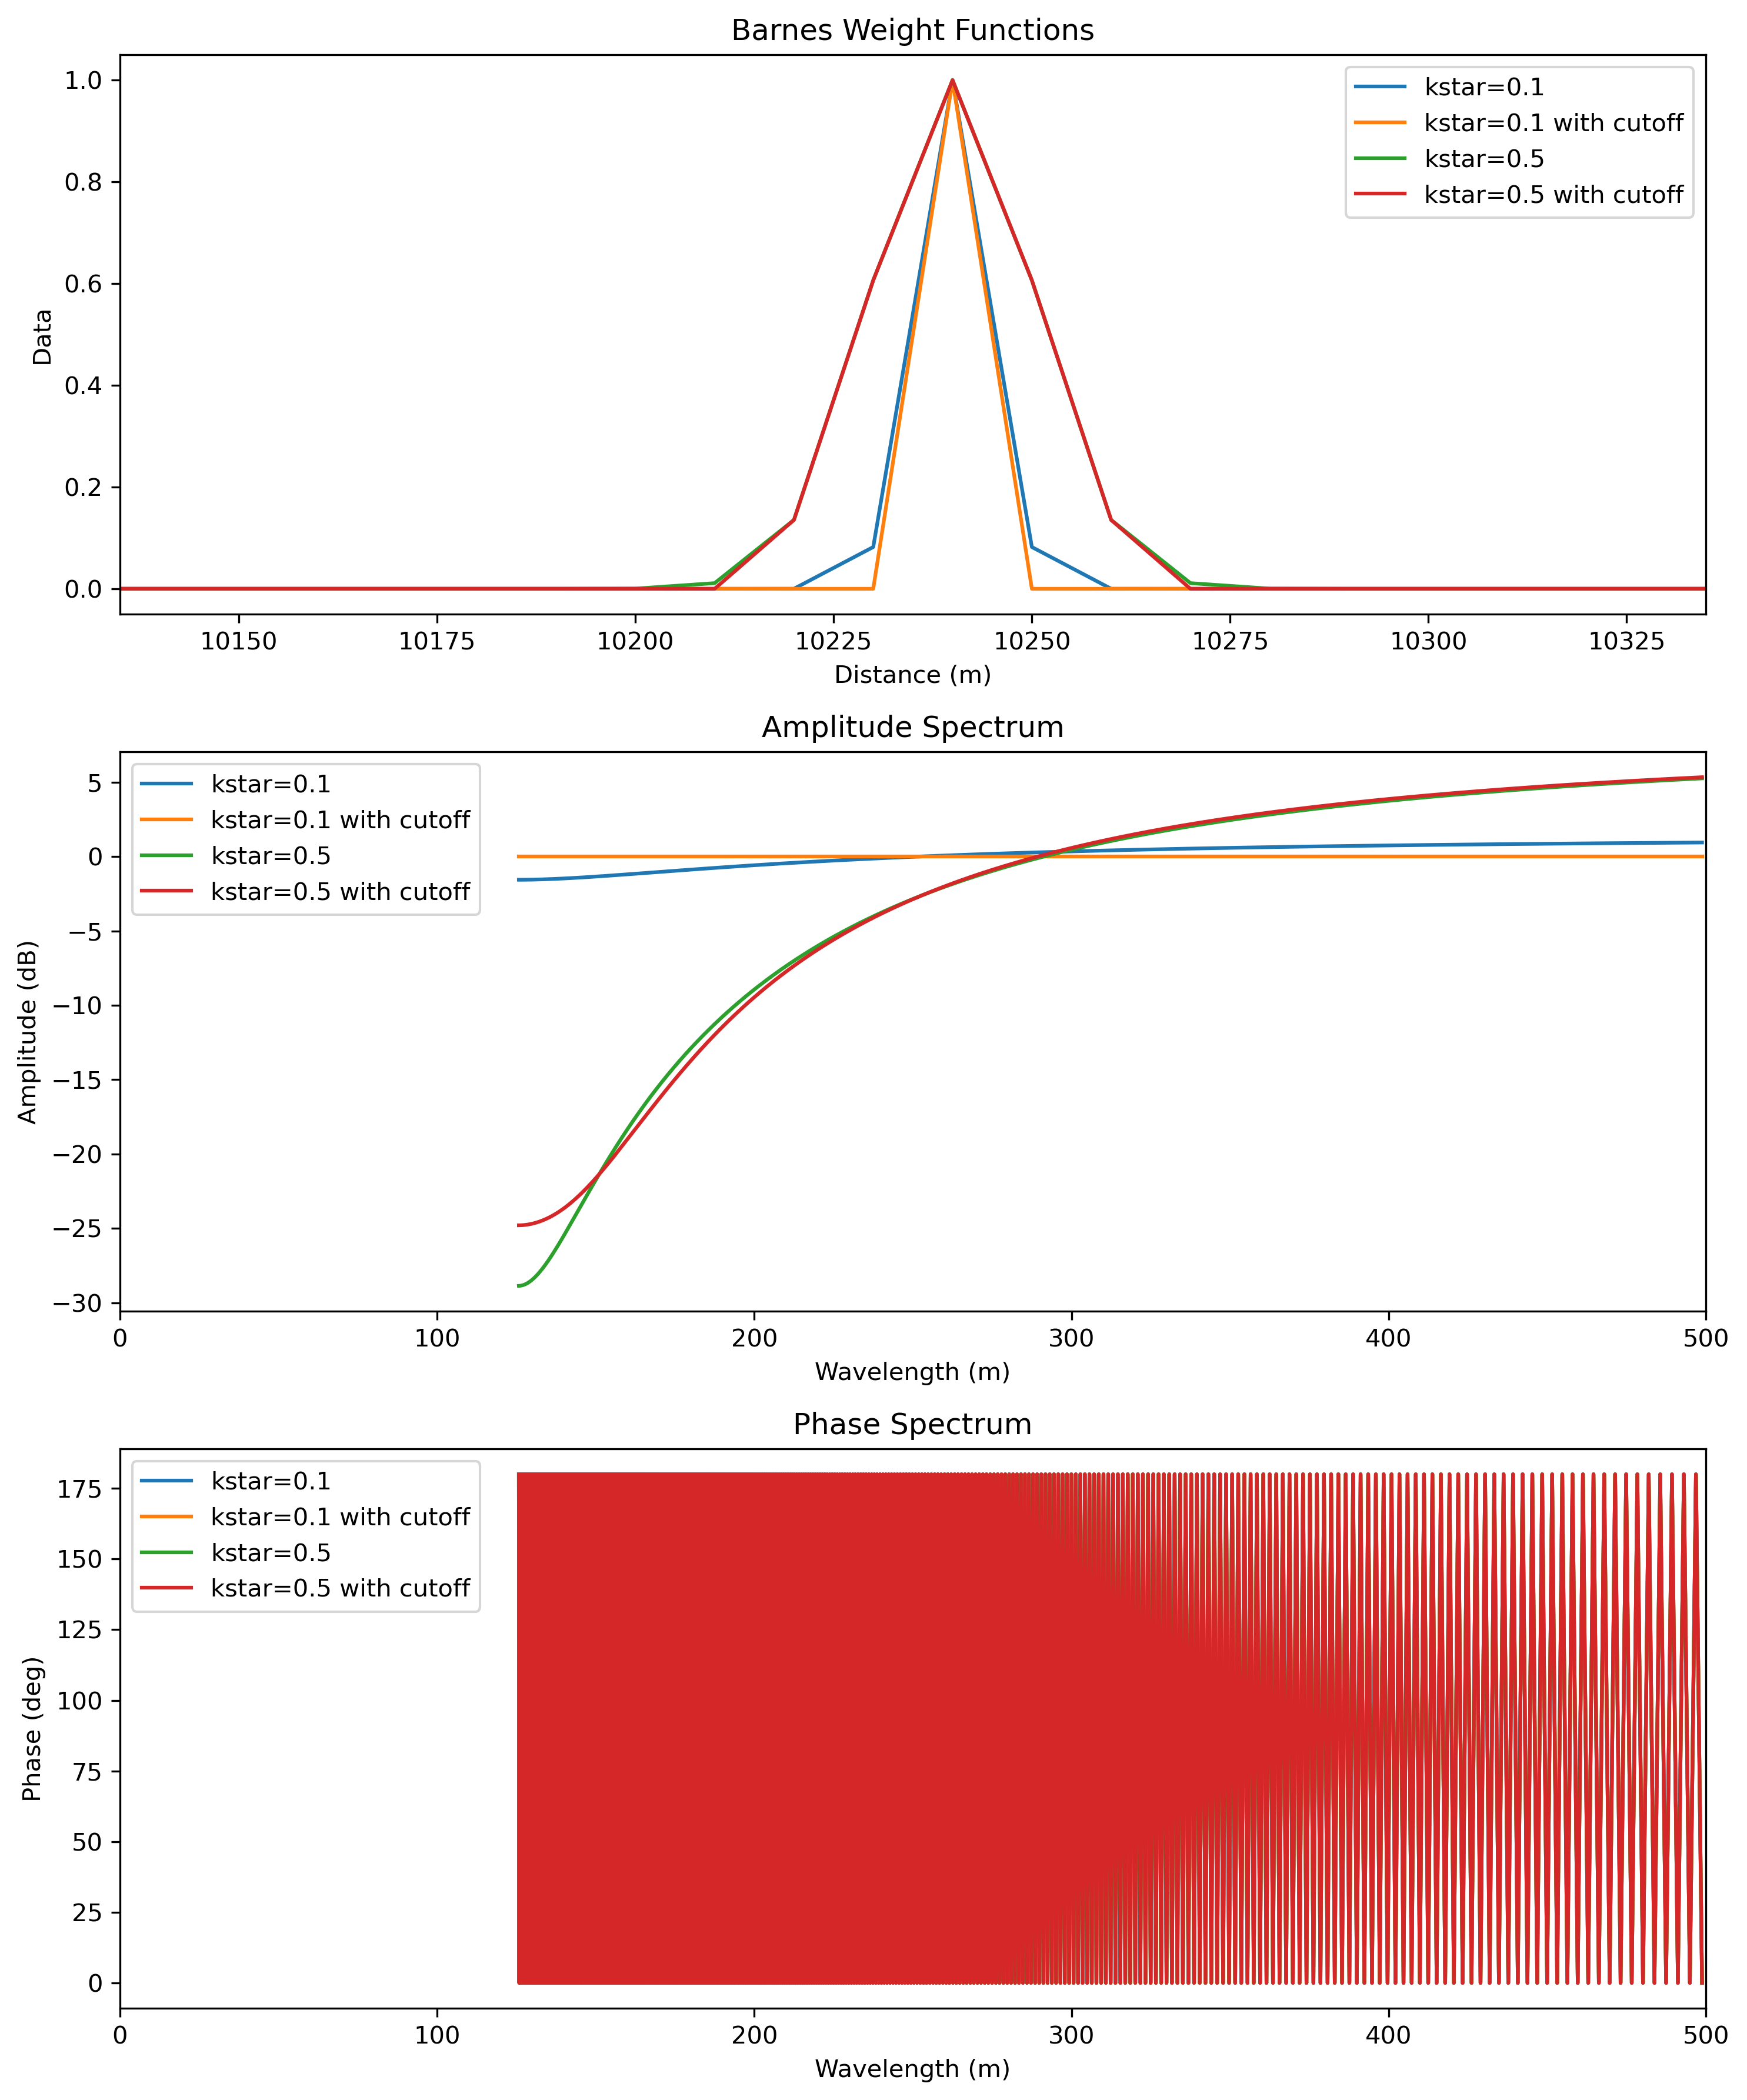

In [7]:
# Calculate the frequency axis for the Fourier transform
#freqs = np.fft.fftfreq(N, delta)

# Prepare the plotting function and axes
fig, axes = plt.subplots(3, 1, figsize=(10, 12), dpi=300)

# Plot the original signals and their Fourier Transforms with proper labeling
axes[0].plot(x, signals[0], label=labels[0])
axes[0].plot(x, signals[1], label=labels[1])
axes[0].plot(x, signals[2], label=labels[2])
axes[0].plot(x, signals[3], label=labels[3])
axes[0].set_xlim(x.max()/2 - 100, x.max()/2 + 100)
axes[0].set_xlabel('Distance (m)')
axes[0].set_ylabel('Data')
axes[0].set_title('Barnes Weight Functions')
axes[0].legend()

# Plot the Fourier Transform amplitude spectrum
for i, signal in enumerate(signals):
    fft_signal = np.fft.fft(signal)
    amplitude_spectrum = np.abs(fft_signal)
    # Convert frequencies to wavelengths, use only positive frequencies
    wavelengths = 2 * np.pi / freqs[:N//2]
    # Apply the wavelength filter
    valid_indices = (wavelengths <= 500) & (wavelengths > 0)
    axes[1].plot(wavelengths[valid_indices], 20*np.log10(amplitude_spectrum[:N//2][valid_indices]), label=labels[i])

axes[1].set_xlim(0, 500)
axes[1].set_xlabel('Wavelength (m)')
axes[1].set_ylabel('Amplitude (dB)')
axes[1].set_title('Amplitude Spectrum')
axes[1].legend()

# Plot the Fourier Transform phase spectrum
for i, signal in enumerate(signals):
    fft_signal = np.fft.fft(signal)
    phase_spectrum = np.angle(fft_signal)
    # Apply the same wavelength filter for phase
    axes[2].plot(wavelengths[valid_indices], np.degrees(phase_spectrum[:N//2][valid_indices]), label=labels[i])

axes[2].set_xlim(0, 500)
axes[2].set_xlabel('Wavelength (m)')
axes[2].set_ylabel('Phase (deg)')
axes[2].set_title('Phase Spectrum')
axes[2].legend()

# Display the plot
plt.tight_layout()
plt.show()


- In summary, these plots indicate that different choices of kappa_star can significantly affect both the amplitude and phase of the weighted data in the frequency domain. This can be crucial in applications such as data smoothing or interpolation, where the influence of nearby versus distant points needs to be balanced appropriately.

- The amplitude plot shows how much of each frequency is

**3.** Instead of weighting with the distance dependent weighting function you wrote, let's use the built-in Gaussian function: `from scipy.signal.windows import gaussian`. It is formulated in terms of the standard deviation. In lecture we derived the relationship $\sigma = \sqrt{2\kappa^*}$. 

Reproduce your plot above using the built-in Gaussian window (weight) function.

C:\Users\dayo\py39\envs\izi_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


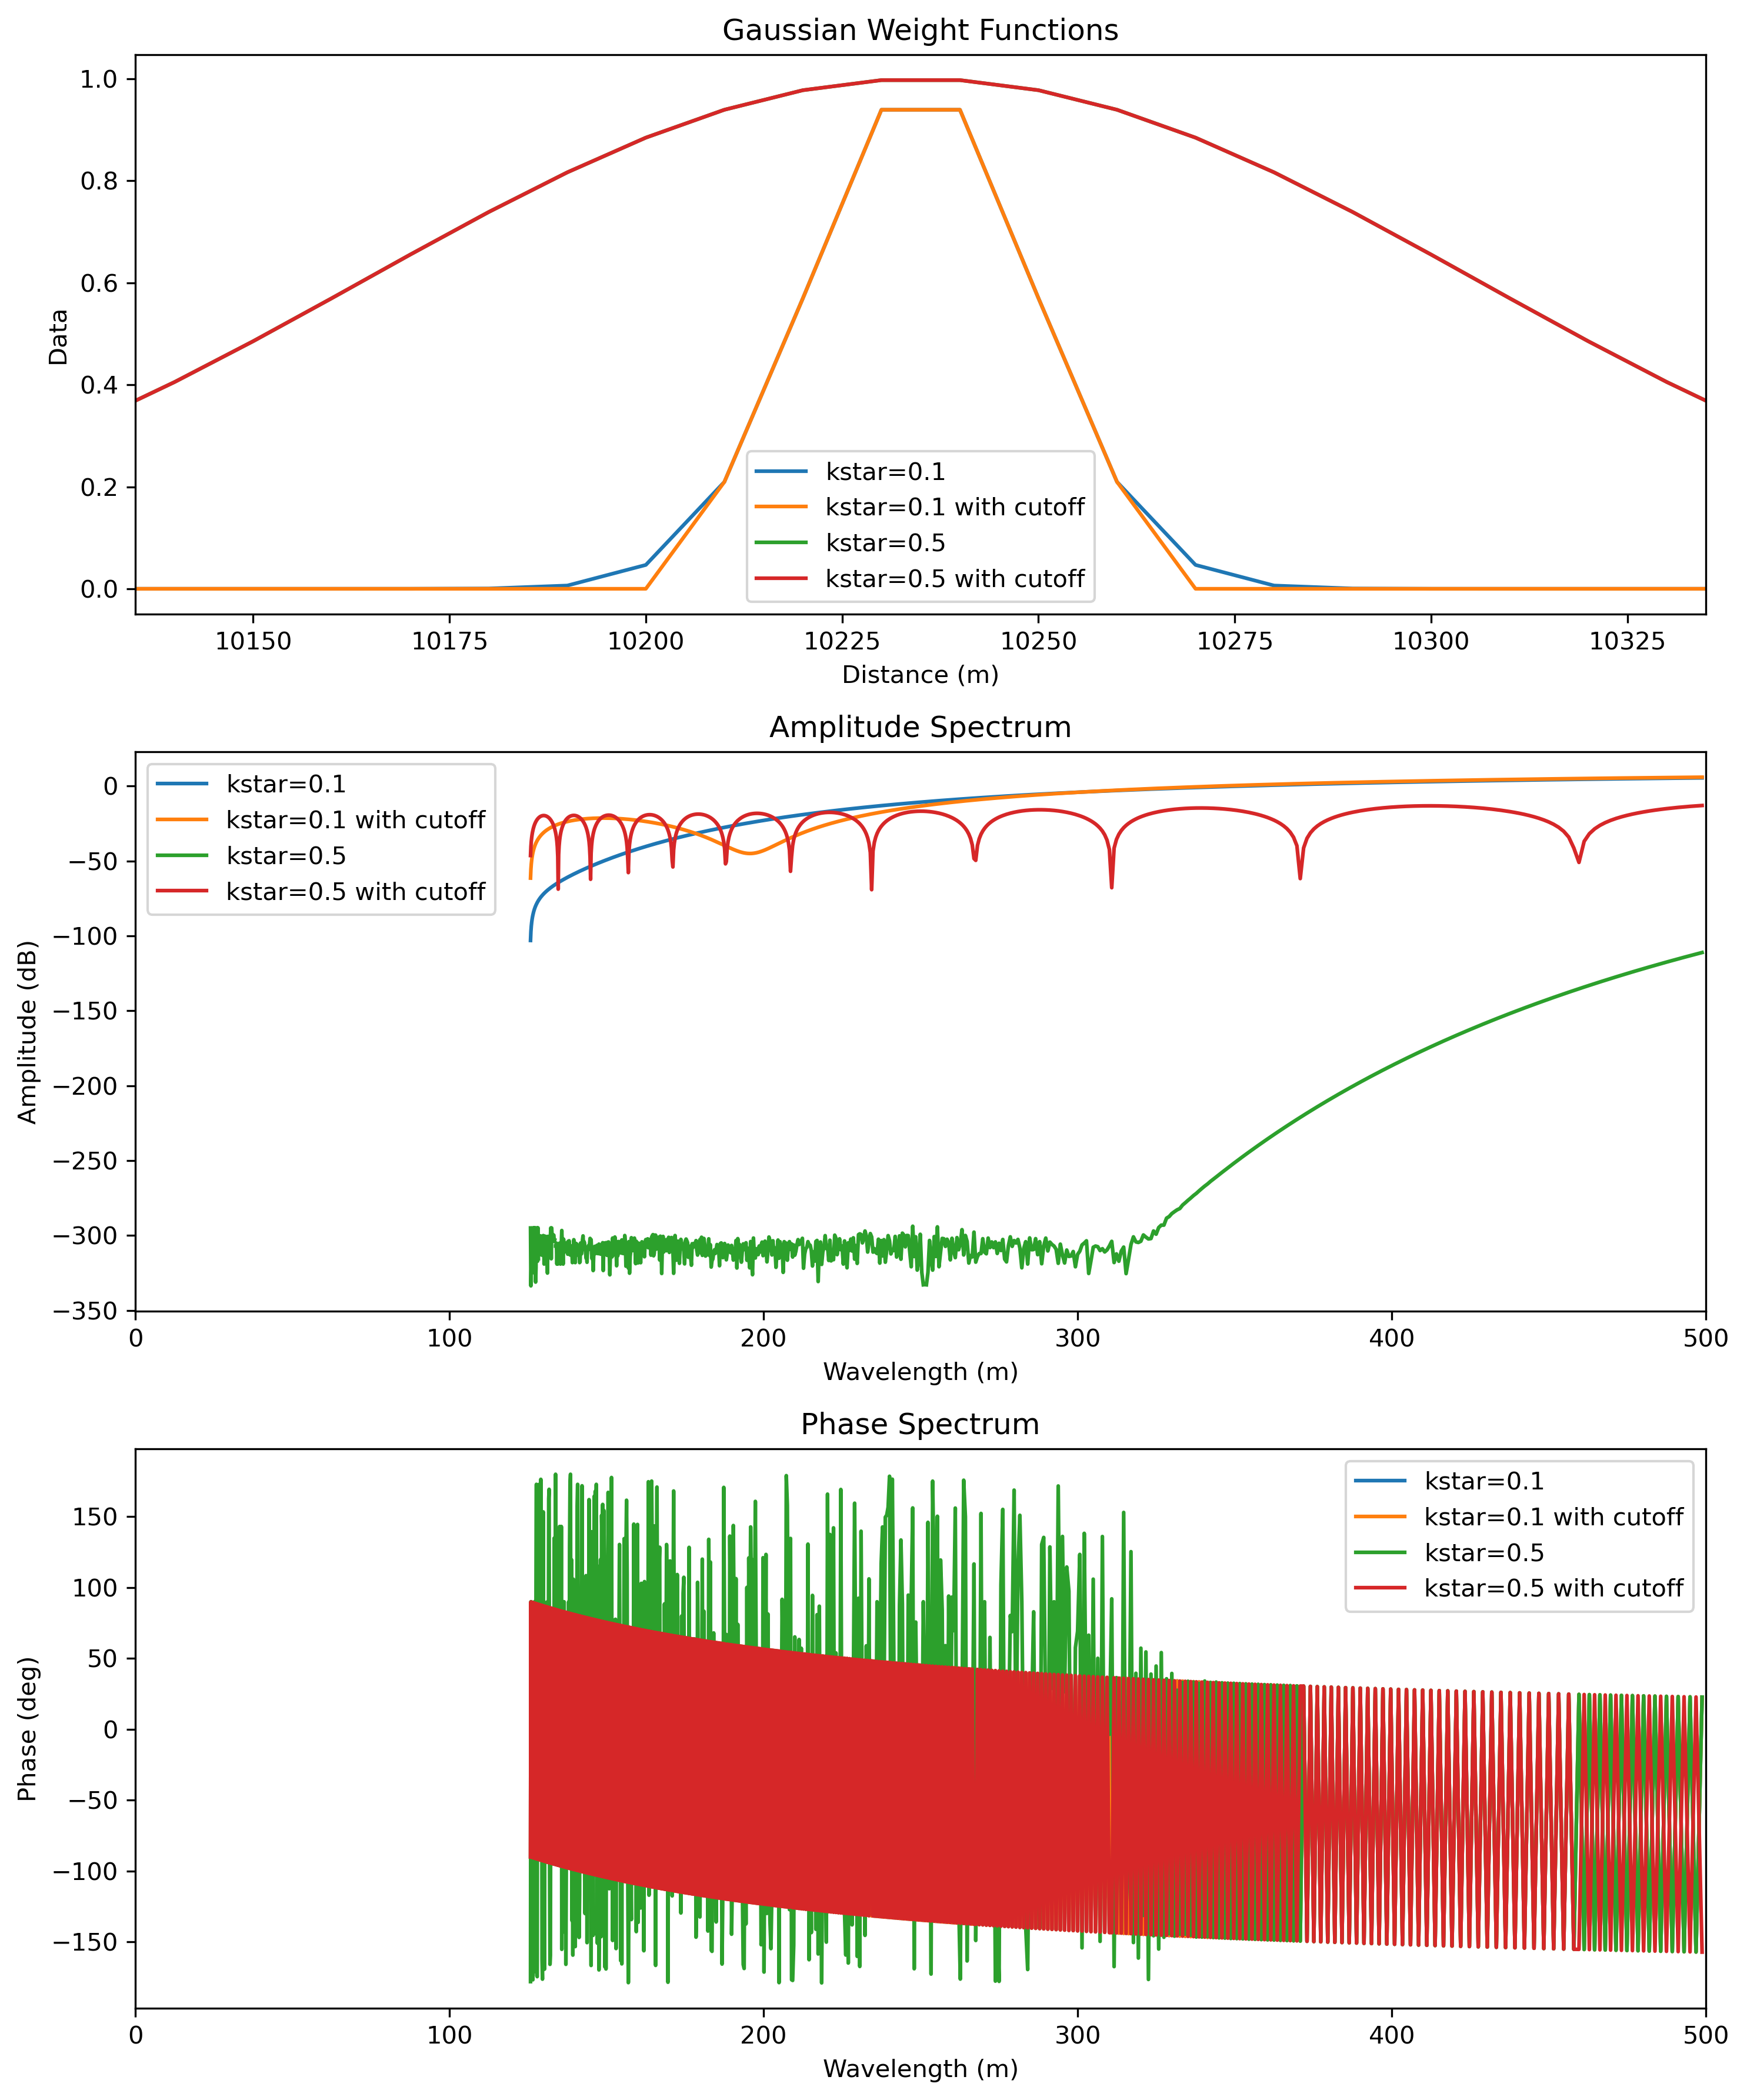

In [8]:
from scipy.signal.windows import gaussian
from scipy.fft import fft, fftfreq, fftshift

# Generate x-axis for the signals
x = np.arange(N) * delta  # The distance axis

# Define the Gaussian weighting function using scipy
def gaussian_weights(N, delta, kappa_star):
    sigma = np.sqrt(2) * kappa_star * delta  
    r = x - N*delta/2  # Center the function at the middle of x
    return gaussian(N, std=sigma)

# Generate Gaussian weights for each kappa_star and apply cutoff
gaussian_signals = []
gaussian_labels = []  # Initialize the labels list
for kappa_star in kappa_star_values:
    weights = gaussian_weights(N, delta, kappa_star)
    gaussian_signals.append(weights)  # Append weights without cutoff
    gaussian_labels.append(f'kstar={kappa_star}')  # Label without cutoff

    weights_cutoff = np.copy(weights)
    weights_cutoff[weights < 0.1] = 0
    gaussian_signals.append(weights_cutoff)  # Append with cutoff weights
    gaussian_labels.append(f'kstar={kappa_star} with cutoff')  # Label with cutoff

# Prepare the plotting function and axes
fig, axes = plt.subplots(3, 1, figsize=(10, 12), dpi=300)

# Plot the Gaussian signals and their Fourier Transforms with proper labeling
axes[0].plot(x, gaussian_signals[0], label=gaussian_labels[0])
axes[0].plot(x, gaussian_signals[1], label=gaussian_labels[1])
axes[0].plot(x, gaussian_signals[2], label=gaussian_labels[2])
axes[0].plot(x, gaussian_signals[3], label=gaussian_labels[3])
axes[0].set_xlim(x.max()/2 - 100, x.max()/2 + 100)
axes[0].set_xlabel('Distance (m)')
axes[0].set_ylabel('Data')
axes[0].set_title('Gaussian Weight Functions')
axes[0].legend()

# Calculate the frequency axis for the Fourier transform
freqs = fftfreq(N, delta)

# Plot the Fourier Transform amplitude spectrum
for i, signal in enumerate(gaussian_signals):
    fft_signal = fft(signal)
    amplitude_spectrum = np.abs(fft_signal)
    # Convert frequencies to wavelengths, use only positive frequencies
    wavelengths = 2 * np.pi / freqs[:N//2]
    # Apply the wavelength filter
    valid_indices = (wavelengths <= 500) & (wavelengths > 0)
    axes[1].plot(wavelengths[valid_indices], 20*np.log10(amplitude_spectrum[:N//2][valid_indices]), label=gaussian_labels[i])

axes[1].set_xlim(0, 500)
axes[1].set_xlabel('Wavelength (m)')
axes[1].set_ylabel('Amplitude (dB)')
axes[1].set_title('Amplitude Spectrum')
axes[1].legend()

# Plot the Fourier Transform phase spectrum
for i, signal in enumerate(gaussian_signals):
    fft_signal = fft(signal)
    phase_spectrum = np.angle(fft_signal)
    # Apply the same wavelength filter for phase
    axes[2].plot(wavelengths[valid_indices], np.degrees(phase_spectrum[:N//2][valid_indices]), label=gaussian_labels[i])

axes[2].set_xlim(0, 500)
axes[2].set_xlabel('Wavelength (m)')
axes[2].set_ylabel('Phase (deg)')
axes[2].set_title('Phase Spectrum')
axes[2].legend()

# Display the plot
plt.tight_layout()
plt.show()


**4.** Implement and plot the frequency response for 3- and 5-point rectangular weight (boxcar) functions.

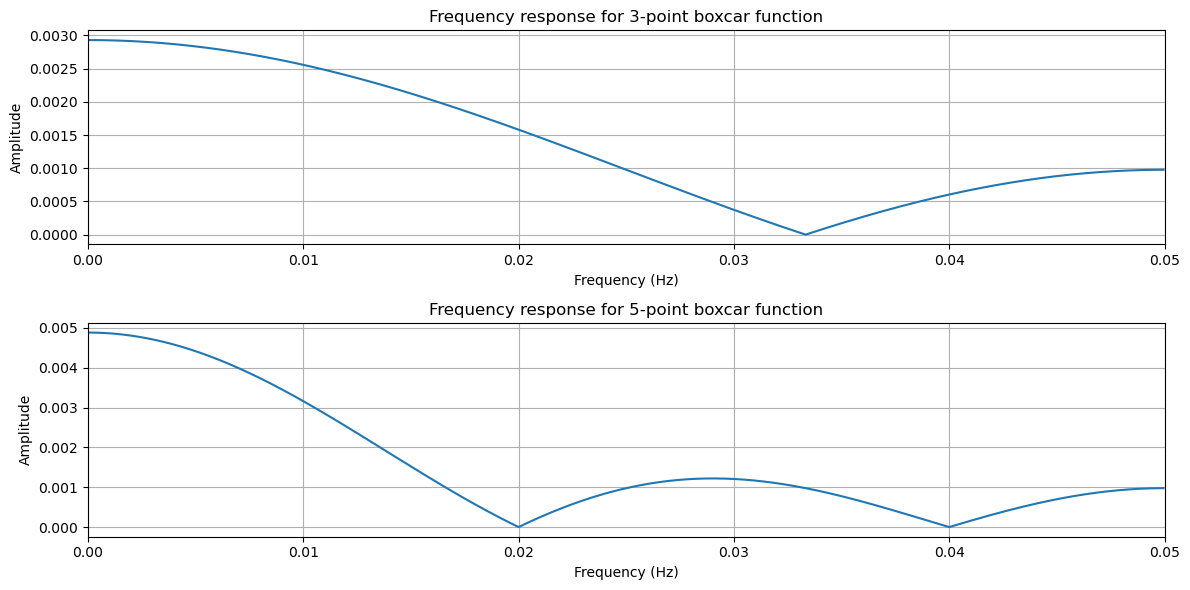

In [9]:
from scipy.fft import fft, fftfreq

# Function to create a boxcar function
def boxcar(N, width):
    signal = np.zeros(N)
    start = N // 2 - width // 2
    signal[start:start+width] = 1
    return signal

# Create a 3-point and 5-point boxcar functions
signal_3_point = boxcar(N, 3)
signal_5_point = boxcar(N, 5)

# Perform FFT
yf_3_point = fft(signal_3_point)
yf_5_point = fft(signal_5_point)

# Generate frequency axis
xf = fftfreq(N, delta)[:N//2]  

# Plotting the frequency response
plt.figure(figsize=(12, 6))

# 3-point boxcar function frequency response
plt.subplot(2, 1, 1)
plt.plot(xf, 2.0/N * np.abs(yf_3_point[:N//2]))
plt.title('Frequency response for 3-point boxcar function')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, fn)  # Set x-axis limit to Nyquist frequency

# 5-point boxcar function frequency response
plt.subplot(2, 1, 2)
plt.plot(xf, 2.0/N * np.abs(yf_5_point[:N//2]))
plt.title('Frequency response for 5-point boxcar function')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, fn)  # Set x-axis limit to Nyquist frequency

plt.tight_layout()
plt.show()


**5.** Implement and plot a 5-point Parzen (Riesz) weight function. Also show the effect of an artifical cutoff by removing the weights below 0.1.

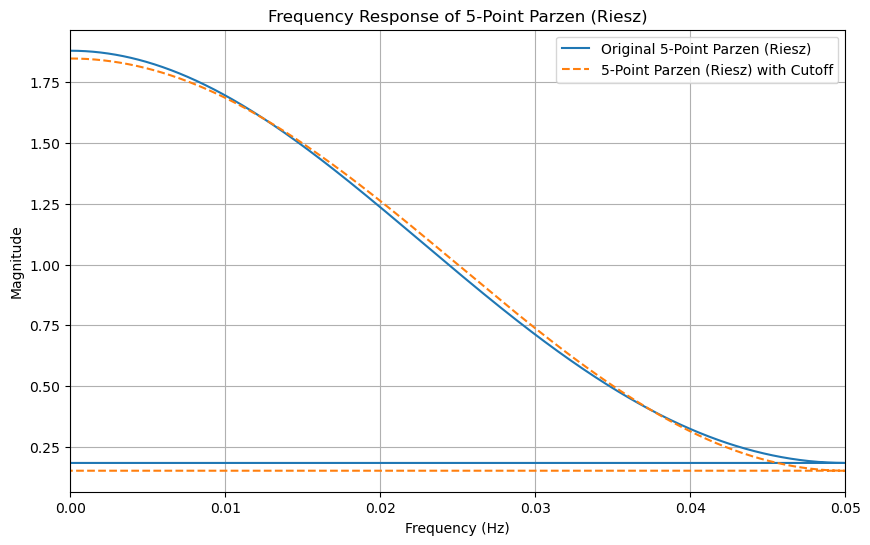

In [10]:
from scipy.signal.windows import parzen

# Generate the 5-point Parzen (Riesz) weight function
parzen_weights = parzen(5)

# Apply the artificial cutoff by setting weights below 0.1 to 0
cutoff = 0.1
parzen_weights_cutoff = np.where(parzen_weights >= cutoff, parzen_weights, 0)

# Compute the frequency response for both the original and cutoff Parzen weights
fft_parzen_original = np.fft.fft(parzen_weights, N)
fft_parzen_cutoff = np.fft.fft(parzen_weights_cutoff, N)

# Create the frequency axis
freqs = np.fft.fftfreq(N, delta)

# Plot the magnitude of the frequency response for both
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.abs(fft_parzen_original), label='Original 5-Point Parzen (Riesz)')
plt.plot(freqs, np.abs(fft_parzen_cutoff), label='5-Point Parzen (Riesz) with Cutoff', linestyle='--')
plt.title('Frequency Response of 5-Point Parzen (Riesz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.xlim(0, fn)  # Limit to Nyquist frequency
plt.show()


**6.** Implement and plot a 5-point Dolph-Chebyshev weight function with a lowest sidelobe level of 60 dB. Also show the effect of an artifical cutoff by removing the weights below 0.1.

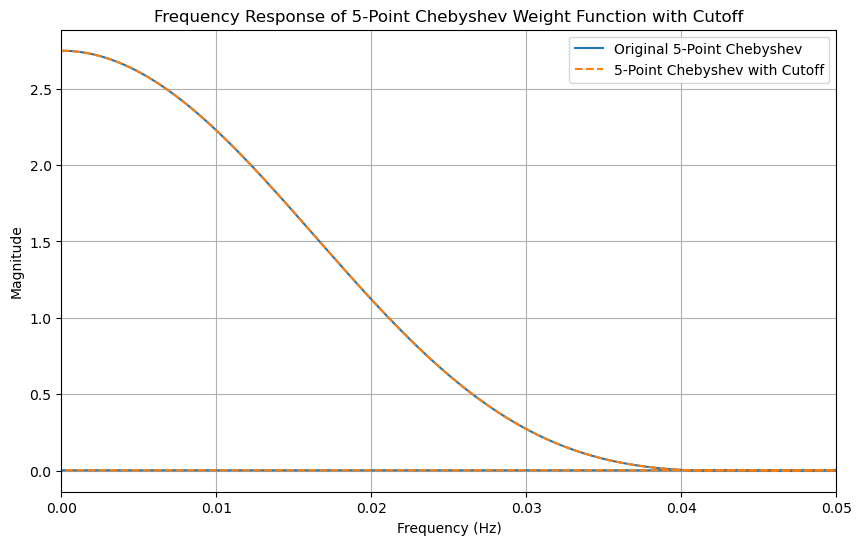

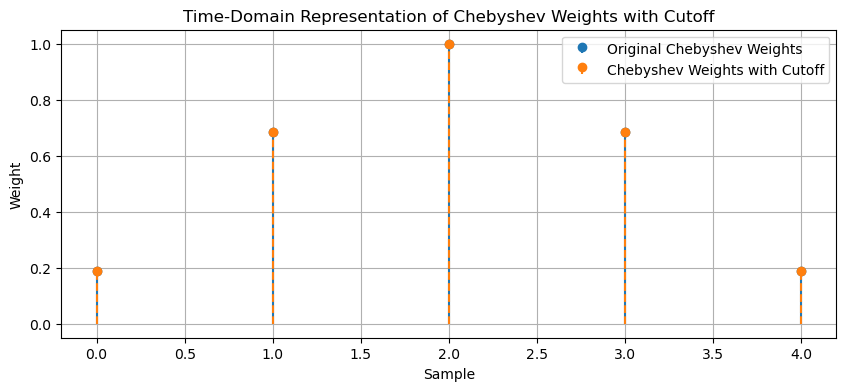

In [11]:
from scipy.signal.windows import chebwin

M = 5      # Number of points in the Chebyshev window
atten = 60 # Attenuation in decibels for the sidelobes

# Generate a 5-point Chebyshev window with the specified sidelobe attenuation
cheby_weights = chebwin(M, at=atten)

# Apply the artificial cutoff by setting weights below 0.1 to 0
cutoff = 0.1
cheby_weights_cutoff = np.where(cheby_weights >= cutoff, cheby_weights, 0)

# Compute the frequency response for the original and cutoff Chebyshev weights
fft_cheby_original = np.fft.fft(cheby_weights, N)
fft_cheby_cutoff = np.fft.fft(cheby_weights_cutoff, N)

# Create the frequency axis
freqs = np.fft.fftfreq(N, delta)

# Plot the magnitude of the frequency response for both
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.abs(fft_cheby_original), label='Original 5-Point Chebyshev')
plt.plot(freqs, np.abs(fft_cheby_cutoff), label='5-Point Chebyshev with Cutoff', linestyle='--')
plt.title('Frequency Response of 5-Point Chebyshev Weight Function with Cutoff')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.xlim(0, fn)  # Limit to Nyquist frequency
plt.show()

# Time-domain representation to ensure the cutoff was applied correctly
plt.figure(figsize=(10, 4))
plt.stem(cheby_weights, basefmt=" ", linefmt='C0-', markerfmt='C0o', label='Original Chebyshev Weights')
plt.stem(cheby_weights_cutoff, basefmt=" ", linefmt='C1--', markerfmt='C1o', label='Chebyshev Weights with Cutoff')
plt.title('Time-Domain Representation of Chebyshev Weights with Cutoff')
plt.xlabel('Sample')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.show()


**7.** Implement and plot a 7-point Blackman and a 7-point Blackman-Harris weight function. There is no need to show the effect of an artificial cutoff here.

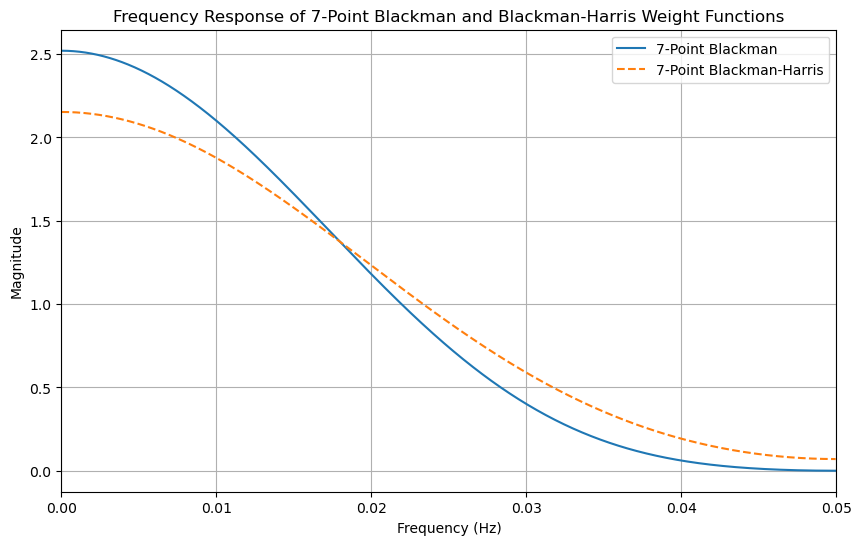

In [12]:
from scipy.signal.windows import blackmanharris, blackman

# Number of points in the window
M = 7

# Generate the 7-point Blackman and Blackman-Harris weight functions
blackman_weights = blackman(M)
blackmanharris_weights = blackmanharris(M)

# Zero padding to match the FFT size
blackman_weights_padded = np.zeros(N)
blackman_weights_padded[:M] = blackman_weights

blackmanharris_weights_padded = np.zeros(N)
blackmanharris_weights_padded[:M] = blackmanharris_weights

# Compute the frequency response for the Blackman and Blackman-Harris weights
fft_blackman = np.fft.fft(blackman_weights_padded)
fft_blackmanharris = np.fft.fft(blackmanharris_weights_padded)

# Create the frequency axis
freqs = np.fft.fftfreq(N, delta)

# Plot the magnitude of the frequency response for both
plt.figure(figsize=(10, 6))
plt.plot(freqs[:N // 2], np.abs(fft_blackman)[:N // 2], label='7-Point Blackman')
plt.plot(freqs[:N // 2], np.abs(fft_blackmanharris)[:N // 2], label='7-Point Blackman-Harris', linestyle='--')
plt.title('Frequency Response of 7-Point Blackman and Blackman-Harris Weight Functions')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.xlim(0, fn)  # Limit to Nyquist frequency
plt.show()


**8.** 

**a.** Plot all weight functions together on the same graph, excluding those that show the effect of an artificial cutoff. Use  `dB_amp=False` to show the amplitude response in linear units. Zoom in as needed to see detail in the most interesting part of the plot.

**b.** Assume our critiera for a best analysis ranks our priorties as follows:
1. Smooth frequency response
2. Minimum amplitude at the Nyquist
3. Maximum amplitude at relatively small wavelengths just next to the Nyquist

Which weight functions are worst by these critera?

Which weight function do you regard as best, and why?

**c.** Compare the Nyquist-crossing amplitudes of the two Gaussian weight functions to the values in Koch et al. (1983), Fig. 1. How does each crossing point differ? What is the reason for the differences?

### Answer to 8(a)
- Let us make the plot interractive for better deduction. 

**Note**: If the plot is not showing, please run the entire code to see the image (output). Also, the frequency domain is adjustable

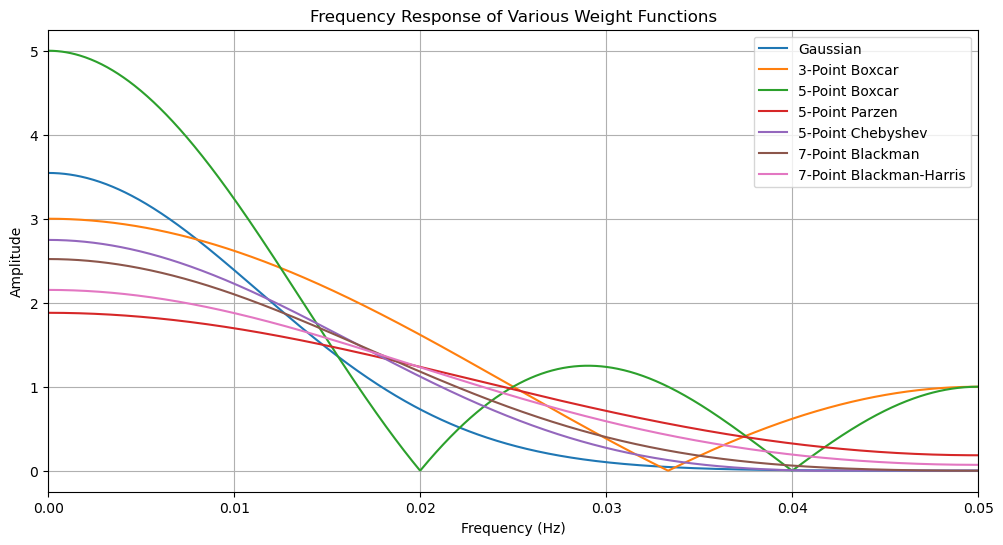

In [13]:
from scipy.signal.windows import gaussian, boxcar, parzen, chebwin, blackman, blackmanharris

kappa_star = 0.1  # Let us use 0.1 in this instance for demonstration

# Calculate standard deviation for the Gaussian window
sigma = np.sqrt(2) * kappa_star * delta  

# Window generation using the computed standard deviation for the Gaussian window
gaussian_weights = gaussian(N, std=sigma)
boxcar_3_weights = boxcar(3)
boxcar_5_weights = boxcar(5)
parzen_weights = parzen(5)
chebwin_weights = chebwin(5, at=60)  # Chebyshev window with 60 dB sidelobe attenuation
blackman_weights = blackman(7)
blackmanharris_weights = blackmanharris(7)

# Zero-padding the shorter windows to match the FFT length
windows = {
    'Gaussian': gaussian_weights,
    '3-Point Boxcar': np.pad(boxcar_3_weights, (0, N - 3), 'constant'),
    '5-Point Boxcar': np.pad(boxcar_5_weights, (0, N - 5), 'constant'),
    '5-Point Parzen': np.pad(parzen_weights, (0, N - 5), 'constant'),
    '5-Point Chebyshev': np.pad(chebwin_weights, (0, N - 5), 'constant'),
    '7-Point Blackman': np.pad(blackman_weights, (0, N - 7), 'constant'),
    '7-Point Blackman-Harris': np.pad(blackmanharris_weights, (0, N - 7), 'constant')
}

# Compute the frequency response for each window
frequency_responses = {name: np.abs(np.fft.fft(window))[:N // 2] for name, window in windows.items()}

# Create the frequency axis
freqs = np.fft.fftfreq(N, delta)[:N // 2]

# Fixed frequency limit for the plot
freq_limit = 0.05  # This can be adjusted, as in the case below
#freq_limit = 0.02  


# Plotting
plt.figure(figsize=(12, 6))
for name, response in frequency_responses.items():
    plt.plot(freqs, response, label=name)
plt.title('Frequency Response of Various Weight Functions')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.xlim(0, freq_limit)
plt.show()


### Answer to 8(b)

Based on the `plot` and the `given` criteria:

<u>**Worst weight function:**</u>

The Boxcar (Rectangular) windows (both 3-point and 5-point) would likely be the worst because they have significant sidelobes and abrupt transitions, which do not provide a smooth frequency response. They also tend to have a relatively high amplitude near the Nyquist frequency due to their sharp cutoff in the time domain.


<u>**Best weight function:**</u>

The Blackman-Harris window would be considered the best among the plotted options because it typically provides a smooth frequency response with low sidelobes due to its design, which incorporates additional cosine terms. It also seems to maintain a higher amplitude at frequencies just below the Nyquist and then roll off more substantially at the Nyquist frequency itself.
I feel that "best" can be quite subjective and depends heavily on the specific requirements of the application. In some applications, the absolute minimum at the Nyquist frequency might be the most critical factor, while in others, the smoothness of the frequency response might be prioritized.

### Answer to 8(c)

The first pass response value in Koch et al. (1983), Fig. 1 is approximately **0.973** at the Nyquist wavelength, while that of the Gaussian window is  **lower**, considering the rapid decay of the Gaussian window's frequency response. Although, that of Kappa star at 0.5 is much closer since it has a broader spread in the frequency domain.

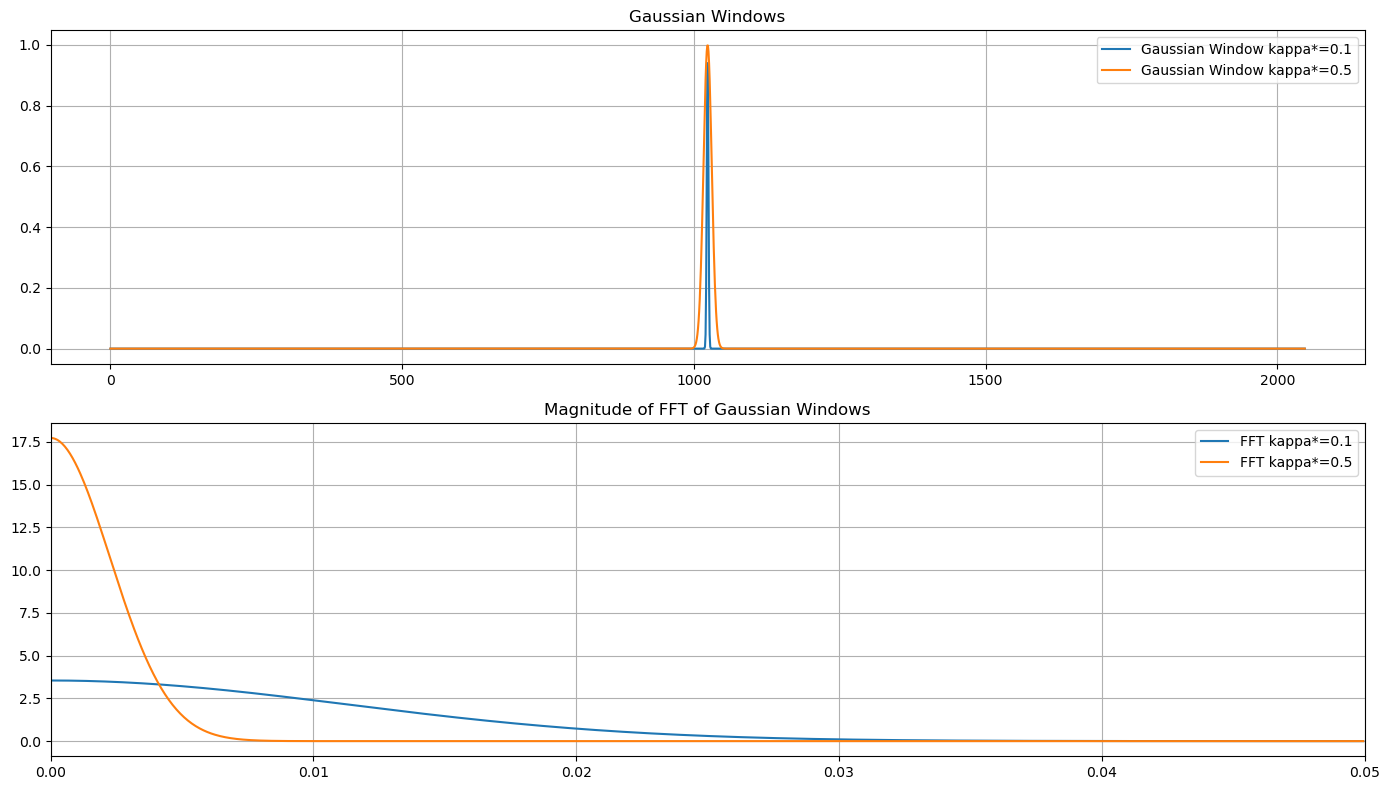

In [14]:
import numpy as np
from scipy.signal.windows import gaussian
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# Constants for the problem
N = 2048
delta = 10  # Sample spacing
fs = 1.0 / delta  # Spatial sampling frequency
fn = fs / 2  # Nyquist frequency

# Given kappa_star values
kappa_star_values = [0.1, 0.5]

# Generate Gaussian windows with the calculated standard deviations
gaussian_weights = {kappa_star: gaussian(N, std=np.sqrt(2) * kappa_star * delta) for kappa_star in kappa_star_values}

# Plot the Gaussian windows and their FFTs
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for kappa_star, weights in gaussian_weights.items():
    # Compute the frequency response
    fft_response = fft(weights)
    freqs = fftfreq(N, delta)
    
    # Plot the window
    axes[0].plot(weights, label=f'Gaussian Window kappa*={kappa_star}')
    
    # Plot the magnitude of the frequency response
    axes[1].plot(freqs[:N//2], np.abs(fft_response)[:N//2], label=f'FFT kappa*={kappa_star}')

axes[0].set_title('Gaussian Windows')
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Magnitude of FFT of Gaussian Windows')
axes[1].set_xlim(0, fs/2)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()